# Chess Dataset Analysis

Source: https://www.kaggle.com/datasets/milesh1/35-million-chess-games

Analyzing the rate at which new openings appear over ~3.5 million games ranging from 1950 - 2000.

# Imports

In [1]:
import csv
import collections
import io
import json
import re
import random
import datetime
import math

import numpy as np
import matplotlib.pyplot as plt

import tqdm

# Prepare Data

In [2]:
#1.t    2.date       3.result    4.welo      5.belo   6.len 7.date_c     8.resu_c      9.welo_c     10.belo_c 11.edate_c 12.setup 13.fen 14.resu2_c 15.oyrange 16.bad_len 17.game...
#1      2000.03.14   1-0         2851        None     67    date_false   result_false  welo_false   belo_true edate_true setup_false fen_false result2_false oyrange_false blen_false ### W1.d4 B1.d5 W2.c4 B2.e6 W3.Nc3 B3.Nf6 W4.cxd5 B4.exd5 W5.Bg5 B5.Be7 W6.e3 B6.Ne4 W7.Bxe7 B7.Nxc3 W8.Bxd8 B8.Nxd1 W9.Bxc7 B9.Nxb2 W10.Rb1 B10.Nc4 W11.Bxc4 B11.dxc4 W12.Ne2 B12.O-O W13.Nc3 B13.b6 W14.d5 B14.Na6 W15.Bd6 B15.Rd8 W16.Ba3 B16.Bb7 W17.e4 B17.f6 W18.Ke2 B18.Nc7 W19.Rhd1 B19.Ba6 W20.Ke3 B20.Kf7 W21.g4 B21.g5 W22.h4 B22.h6 W23.Rh1 B23.Re8 W24.f3 B24.Bb7 W25.hxg5 B25.fxg5 W26.d6 B26.Nd5+ W27.Nxd5 B27.Bxd5 W28.Rxh6 B28.c3 W29.d7 B29.Re6 W30.Rh7+ B30.Kg8 W31.Rbh1 B31.Bc6 W32.Rh8+ B32.Kf7 W33.Rxa8 B33.Bxd7 W34.Rh7+ 


In [3]:
# 1.t 2.date 3.result 4.welo 5.belo 6.len 7.date_c 8.resu_c 9.welo_c 10.belo_c 11.edate_c 12.setup 13.fen 14.resu2_c 15.oyrange 16.bad_len 17.game...
# 1 2000.03.14 1-0 2851 None 67 date_false result_false welo_false belo_true edate_true setup_false fen_false result2_false oyrange_false blen_false ### W1.d4 B1.d5 W2.c4 B2.e6 W3.Nc3 B3.Nf6 W4.cxd5 B4.exd5 W5.Bg5 B5.Be7 W6.e3 B6.Ne4 W7.Bxe7 B7.Nxc3 W8.Bxd8 B8.Nxd1 W9.Bxc7 B9.Nxb2 W10.Rb1 B10.Nc4 W11.Bxc4 B11.dxc4 W12.Ne2 B12.O-O W13.Nc3 B13.b6 W14.d5 B14.Na6 W15.Bd6 B15.Rd8 W16.Ba3 B16.Bb7 W17.e4 B17.f6 W18.Ke2 B18.Nc7 W19.Rhd1 B19.Ba6 W20.Ke3 B20.Kf7 W21.g4 B21.g5 W22.h4 B22.h6 W23.Rh1 B23.Re8 W24.f3 B24.Bb7 W25.hxg5 B25.fxg5 W26.d6 B26.Nd5+ W27.Nxd5 B27.Bxd5 W28.Rxh6 B28.c3 W29.d7 B29.Re6 W30.Rh7+ B30.Kg8 W31.Rbh1 B31.Bc6 W32.Rh8+ B32.Kf7 W33.Rxa8 B33.Bxd7 W34.Rh7+ 
def get_games():
    dates_and_games = []
    stats = collections.defaultdict(int)
    with open("data/all_with_filtered_anotations_since1998.txt") as handle:
        for line in tqdm.tqdm(handle):
            try:
                if not line or line.startswith("#"):
                    continue
                # for now we only focus on the date and result of the game as well as the moves.
                date_str = re.findall("\d{4}\.\d{2}\.\d{2}", line[:30])[0]
                date = datetime.datetime.strptime(date_str, "%Y.%m.%d")
                result = re.findall(r"0-1|1-0|0\.5-0\.5", line[:30])[0]
                moves = line.split("###")[1].strip()
                dates_and_games.append(
                    {
                        "date": date,
                        "result": result,
                        "moves":moves,
                    }
                )
                stats['success'] += 1
            except Exception as exc:
                stats[str(exc)] += 1

        return sorted(dates_and_games, key=lambda x: x["date"]), stats
    
games, stats = get_games()
print(f"{100 * stats['success'] / sum(stats.values())}% success rate, {len(games)} games obtained.")

3561475it [00:53, 67103.16it/s] 


30.601212420713917% success rate, 1089853 games obtained.


In [4]:
def filter_games(games):
    """
    Apply some sanity checks
    """
    return [g  for g in games if
            "W10." in g["moves"] and  # the game consists of at least 10 moves from a player
            g['date'] > datetime.datetime(1980,1,1)  # the date is not obviously broken such as 206.01.01
    ]

games_filtered = filter_games(games)
len(games_filtered)





1020412

In [5]:
games_filtered[0]

{'date': datetime.datetime(1980, 1, 2, 0, 0),
 'result': '1-0',
 'moves': 'W1.e4 B1.e6 W2.d4 B2.d5 W3.Nd2 B3.c5 W4.Ngf3 B4.Nc6 W5.exd5 B5.exd5 W6.Bb5 B6.Bd6 W7.dxc5 B7.Bxc5 W8.O-O B8.Ne7 W9.Nb3 B9.Bd6 W10.Bd2 B10.O-O W11.Bc3 B11.Qb6 W12.Bd3 B12.f6 W13.h3 B13.Be6 W14.Nfd4 B14.Bf7 W15.Re1 B15.Be5 W16.Bf1 B16.Rfe8 W17.a4 B17.a6 W18.Qd2 B18.Qc7 W19.g3 B19.Nd8 W20.Bg2 B20.Ne6 W21.Nxe6 B21.Bxe6 W22.Bd4 B22.Bf7 W23.a5 B23.Rac8 W24.c3 B24.Qc4 W25.Bf1 B25.Qc7 W26.Bb6 B26.Qc6 W27.Bg2 B27.Nf5 W28.Qd3 B28.g6 W29.Red1 B29.Ne7 W30.Nc5 B30.Bc7 W31.Na4 B31.Bxb6 W32.Nxb6 B32.Rcd8 W33.c4 B33.Nc8 W34.Nxd5 B34.Kg7 W35.Qc3 B35.Qe6 W36.Nc7 B36.Qxc4 W37.Nxe8+ B37.Rxe8 W38.Qxc4'}

# Base stats

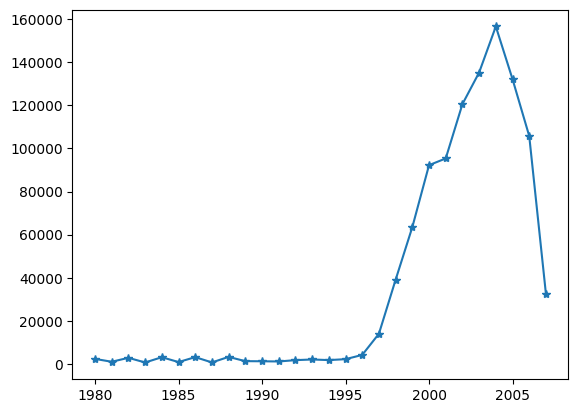

In [6]:
cc = collections.Counter([int(g['date'].year) for g in games_filtered])
plt.plot(sorted(cc.keys()), [cc[x] for x in sorted(cc.keys())], "*-")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1020412/1020412 [00:27<00:00, 36570.10it/s]


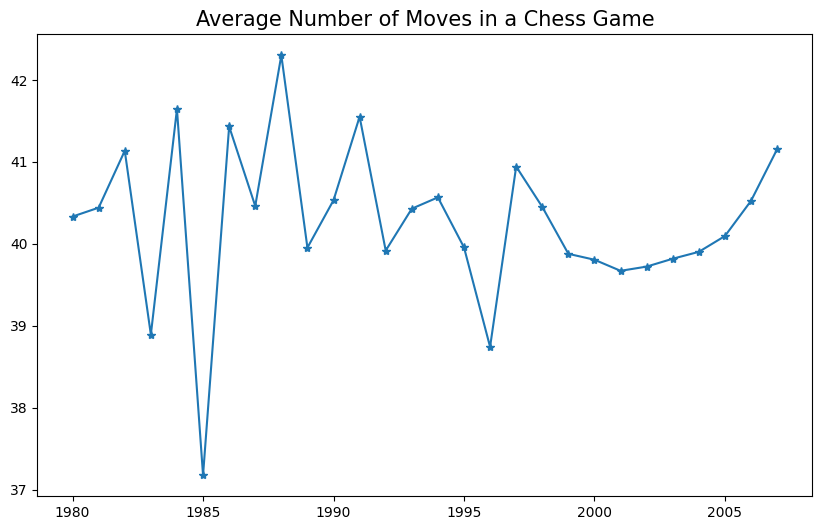

In [7]:
annual_moves = collections.defaultdict(list)
for game in tqdm.tqdm(games_filtered):
    annual_moves[int(game['date'].year)].append(int(
        re.findall('(\d{1,2})\.', game['moves'])[-1]
    ))

plt.figure(figsize=(10,6))
plt.title("Average Number of Moves in a Chess Game", fontsize=15)

plt.plot(annual_moves.keys(), [sum(annual_moves[k])/ max(1, len(annual_moves[k])) for k in annual_moves], "*-")

# Growth of Different Openings

In [8]:
 def get_moves_only(game):
    return [move.split(".")[1] for move in game['moves'].split(" ")]

## Individual Moves

In [9]:
import itertools

MOVE_PAIR_COUNTS = 10
simple_have_seen = set()
pair_have_seen = set()
indiv_novelties = []
pair_novelties = []

for game in tqdm.tqdm(games_filtered):
    moves_only = get_moves_only(game)[:MOVE_PAIR_COUNTS * 2]
    for item in moves_only:
        simple_have_seen.add(item)
    for item in itertools.combinations(moves_only, 2):
        pair_have_seen.add(item)
    indiv_novelties.append(len(simple_have_seen))
    pair_novelties.append(len(pair_have_seen))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1020412/1020412 [01:13<00:00, 13845.86it/s]


In [10]:
from sklearn.linear_model import LinearRegression
import time

t0 = time.time()
libs_count = indiv_novelties
xs = np.array(range(1, len(libs_count)+1))
xs_transformed = np.log(xs).reshape(-1 ,1 )
counts_transformed = np.log(np.array(libs_count) + 1)

model = LinearRegression()
model.fit(xs_transformed, counts_transformed)

alpha = model.coef_[0]
log_c = model.intercept_
c = np.exp(log_c)
t1 = time.time()

print(f"Fit took {round(t1-t0, 2)} seconds")
print(f"Fit performed; alpha={alpha} c={c}")

Fit took 0.16 seconds
Fit performed; alpha=0.16312489084680812 c=181.33020166796368


Text(0.5, 1.0, 'Chess Openings - 10 pairs of moves')

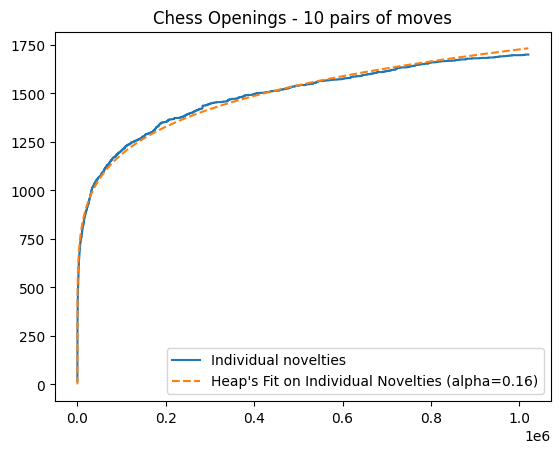

In [11]:
xs = list(range(len(indiv_novelties)))
plt.plot(xs, indiv_novelties, label="Individual novelties")
#plt.plot(xs, pair_novelties, label="Combinatorial novelties")
plt.plot(xs, [c * x ** alpha for x in xs], "--", label=f"Heap's Fit on Individual Novelties (alpha={round(alpha, 2)})")
#plt.plot(xs, [(c * x ** alpha) * (c * x ** alpha - 1) / 2 for x in xs], "--", label=f"Heap's Theoretical Upper bound on comb. novelties")

plt.legend()
plt.title(f"Chess Openings - {MOVE_PAIR_COUNTS} pairs of moves")
#plt.loglog()

In [12]:
MOVE_COUNTS = range(1,11)

have_seen = {move_count: set() for move_count in MOVE_COUNTS}
counts = {move_count: [] for move_count in MOVE_COUNTS}

for index, game in tqdm.tqdm(enumerate(games_filtered)):
    moves_only = get_moves_only(game)
    for move_count in MOVE_COUNTS:
        init_moves = moves_only[:2 * move_count]
        move_hash = "".join(init_moves)
        have_seen[move_count].add(move_hash)
        counts[move_count].append(len(have_seen[move_count]))

1020412it [00:31, 32550.87it/s]


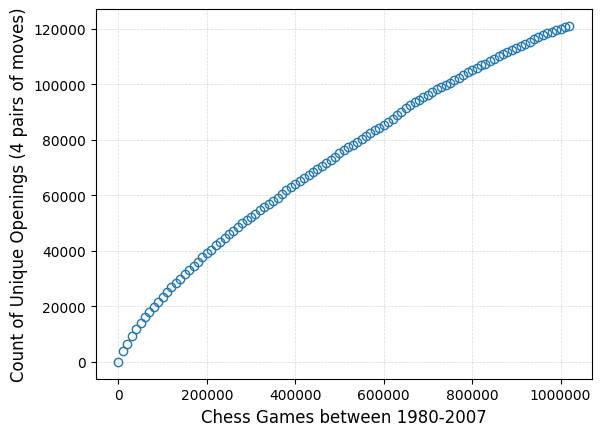

In [13]:
import matplotlib.ticker as mticker

plt.figure()
plt.xlabel("Chess Games between 1980-2007", fontsize=12)
plt.ylabel("Count of Unique Openings (4 pairs of moves)", fontsize=12)

MOVE_COUNTS = [4]
STEP_SIZE = 10_000
for index, move_count in enumerate(MOVE_COUNTS):
    plt.plot(range(0, len(counts[move_count]), STEP_SIZE), counts[move_count][::STEP_SIZE],"o", label=f"First {move_count} pairs of moves",
            markerfacecolor='none')    

def format_with_commas(x):
    return '{:,}'.format(int(x))

# # Customize ticks to remove scientific notation
formatter = mticker.ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
plt.gca().xaxis.set_major_formatter(formatter)
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.5)



# Heatmaps of various field properties

In [14]:
def field_to_coordinates(field):
    return (8 - int(field[1]), 'abcdefgh'.index(field[0]))

## Captures

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1020412/1020412 [00:08<00:00, 115849.48it/s]


Text(0.5, 1.0, 'Capture Frequency on the Chess Board')

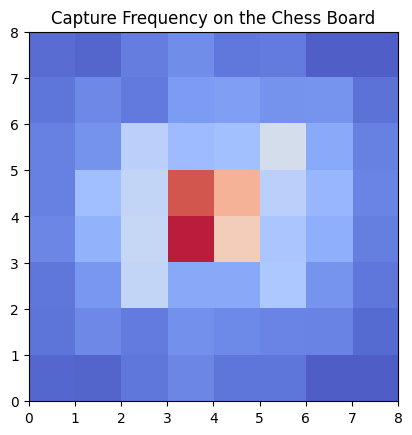

In [15]:
capture_fields = collections.defaultdict(int)
for game in tqdm.tqdm(games_filtered):
    for capture in re.findall("x([a-z][1-8])", game['moves']):
        capture_fields[capture] += 1
          

fig, ax = plt.subplots()
chessboard = np.zeros((8, 8))
#chessboard[1::2, 0::2] = 1
#chessboard[0::2, 1::2] = 1

ax.imshow(chessboard, cmap='binary', interpolation='nearest', extent=[0, 8, 0, 8])

data = np.array([
    np.array([0 for y in range(8)])
    for x in range(8)
])
for k, v in capture_fields.items():
    data[field_to_coordinates(k)] = v

im = ax.imshow(data, alpha=0.9, cmap='coolwarm', interpolation='nearest', extent=[0, 8, 0, 8])
ax.set_title("Capture Frequency on the Chess Board")

## Losing King's position at the time of checkmate

In [16]:
# NOTE: this is a very small subset of games; normally GMs resigns way before checkmate can happen
checkmate_games = [g for g in games_filtered if g['moves'][-1] == "#"];len(checkmate_games)

67325

In [17]:
stats = collections.defaultdict(int)
white_checkmate_fields = collections.defaultdict(int)
black_checkmate_fields = collections.defaultdict(int)

for game in checkmate_games:
    # find the losing king's last known position such as W20.Ke3
    if game['result'] not in ['1-0', '0-1']:
        stats['wrong'] += 1
        continue
    if game['result'] == '1-0':
        king_positions = re.findall("B\d{1,3}\.K(?:x)?[abcdefgh][12345678]", game['moves'])
        king_last_seen = king_positions[-1] if king_positions else 'e8'
        stats['white'] +=1
        black_checkmate_fields[king_last_seen[-2:]] += 1
    elif game['result'] == '0-1':
        king_positions = re.findall("W\d{1,3}\.K(?:x)?[abcdefgh][12345678]", game['moves'])
        king_last_seen = king_positions[-1] if king_positions else 'e1'
        stats['black'] += 1
        white_checkmate_fields[king_last_seen[-2:]] += 1
stats

defaultdict(int, {'black': 30849, 'white': 36476})

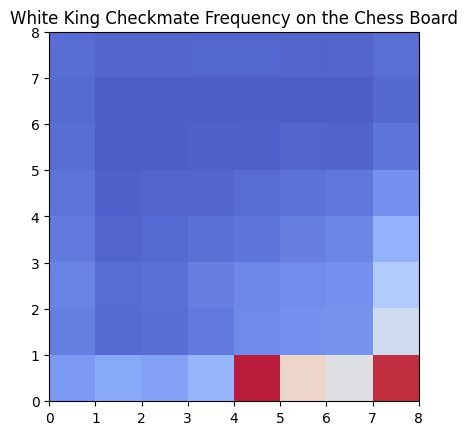

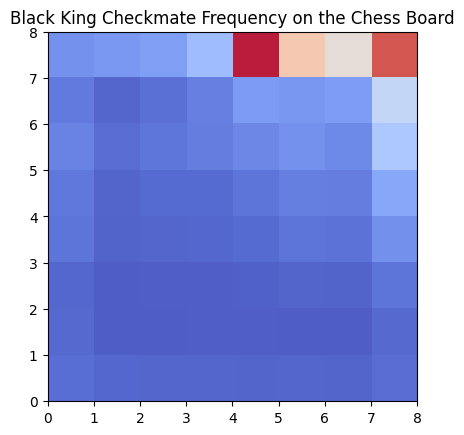

In [18]:
for color, checkmate_fields in {
    'White': white_checkmate_fields,
    "Black": black_checkmate_fields,
}.items():
    fig, ax = plt.subplots()
    chessboard = np.zeros((8, 8))
    #chessboard[1::2, 0::2] = 1
    #chessboard[0::2, 1::2] = 1

    ax.imshow(chessboard, cmap='binary', interpolation='nearest', extent=[0, 8, 0, 8])

    data = np.array([
        np.array([0 for y in range(8)])
        for x in range(8)
    ])
    for k, v in checkmate_fields.items():
        data[field_to_coordinates(k)] = v

    im = ax.imshow(data, alpha=0.9, cmap='coolwarm', interpolation='nearest', extent=[0, 8, 0, 8])
    ax.set_title(f"{color} King Checkmate Frequency on the Chess Board")

# FICS GAMES DB